In [1]:
import os
import glob
import random
import numpy as np
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import normalize, to_categorical
from keras.metrics import MeanIoU
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import segmentation_models as sm

C:\Users\786ah\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


Segmentation Models: using `keras` framework.


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Set the framework for segmentation models
sm.set_framework('tf.keras')


In [12]:
# Constants
SIZE_X = 128
SIZE_Y = 128
N_CLASSES = 7  # Number of classes for segmentation
BACKBONES = ['resnet34', 'mobilenetv2', 'vgg16']
BATCH_SIZE = 8
EPOCHS = 25
LR = 0.0001
DATA_PATH = 'PycharmProjects/Project_1/sandstone_patches/images/images/'
MASK_PATH = 'PycharmProjects/Project_1/sandstone_patches/masks/'

In [13]:
# Function to load images
def load_images(data_path, mask_path):
    train_images = []
    train_masks = []

    for directory_path in glob.glob(data_path):
        for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
            img = cv2.imread(img_path, 1)
            train_images.append(img)

    for directory_path in glob.glob(mask_path):
        for mask_path in glob.glob(os.path.join(directory_path, "*.jpg")):
            mask = cv2.imread(mask_path, 0)
            train_masks.append(mask)

    train_images = np.array(train_images)
    train_masks = np.array(train_masks)

    return train_images, train_masks

# Function to preprocess masks
def preprocess_masks(masks):
    labelencoder = LabelEncoder()
    print(masks.shape)
    n, h, w = masks.shape
    masks_reshaped = masks.reshape(-1, 1)
    masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
    masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)
    return masks_encoded_original_shape

# Function to create train-test split
def split_data(images, masks, test_size=0.1, random_state=0):
    masks_input = np.expand_dims(masks, axis=3)
    X1, X_test, y1, y_test = train_test_split(images, masks_input, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X1, y1, test_size=test_size, random_state=random_state)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Function to perform data augmentation
def augment_data(X_train, y_train, batch_size):
    data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode='nearest')
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    seed = 1
    image_datagen.fit(X_train, augment=True, seed=seed)
    mask_datagen.fit(y_train, augment=True, seed=seed)

    image_generator = image_datagen.flow(X_train, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)

    return zip(image_generator, mask_generator)

# Function to build and compile a model
def build_model(backbone, n_classes, input_shape=(SIZE_X, SIZE_Y, 3), activation='softmax'):
    preprocess_input = sm.get_preprocessing(backbone)
    model = sm.Unet(backbone, encoder_weights='imagenet', classes=n_classes, activation=activation)
    model.compile(keras.optimizers.Adam(LR), loss=sm.losses.DiceLoss() + sm.losses.CategoricalFocalLoss(),
                  metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
    return model, preprocess_input

# Function to plot training history
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    iou = history.history['iou_score']
    val_iou = history.history['val_iou_score']
    plt.plot(epochs, iou, 'y', label='Training IOU')
    plt.plot(epochs, val_iou, 'r', label='Validation IOU')
    plt.title('Training and validation IOU')
    plt.xlabel('Epochs')
    plt.ylabel('IOU')
    plt.legend()
    plt.show()

    fscore = history.history['f1-score']
    val_fscore = history.history['val_f1-score']
    plt.plot(epochs, fscore, 'y', label='Training FScore')
    plt.plot(epochs, val_fscore, 'r', label='Validation FScore')
    plt.title('Training and validation FScore')
    plt.xlabel('Epochs')
    plt.ylabel('FScore')
    plt.legend()
    plt.show()

(1600, 128, 128)


C:\Users\786ah\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\786ah\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:2094: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1296, 128, 128, 7) (7 channels).
  warnings.warn(
C:\Users\786ah\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1296, 128, 128, 7) (7 channels).
  warnings.warn(


Epoch 1/25
162/162 [==============================] - ETA: 0s - loss: 0.8127 - iou_score: 0.2643 - f1-score: 0.3157
Epoch 1: val_loss improved from inf to 0.76417, saving model to resnet34_best_model.h5
162/162 [==============================] - 45s 148ms/step - loss: 0.8127 - iou_score: 0.2643 - f1-score: 0.3157 - val_loss: 0.7642 - val_iou_score: 0.3080 - val_f1-score: 0.3840
Epoch 2/25
162/162 [==============================] - ETA: 0s - loss: 0.6702 - iou_score: 0.4276 - f1-score: 0.5017
Epoch 2: val_loss improved from 0.76417 to 0.63995, saving model to resnet34_best_model.h5
162/162 [==============================] - 15s 93ms/step - loss: 0.6702 - iou_score: 0.4276 - f1-score: 0.5017 - val_loss: 0.6399 - val_iou_score: 0.4248 - val_f1-score: 0.5001
Epoch 3/25
162/162 [==============================] - ETA: 0s - loss: 0.6213 - iou_score: 0.4597 - f1-score: 0.5327
Epoch 3: val_loss improved from 0.63995 to 0.58326, saving model to resnet34_best_model.h5
162/162 [===================

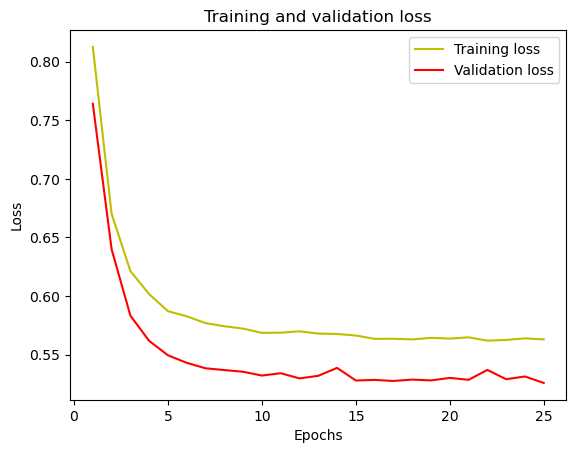

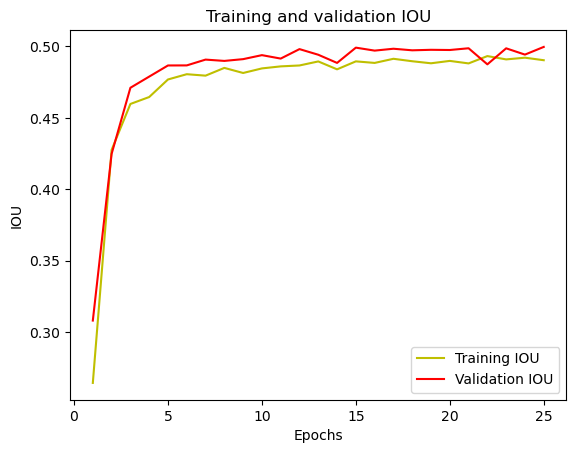

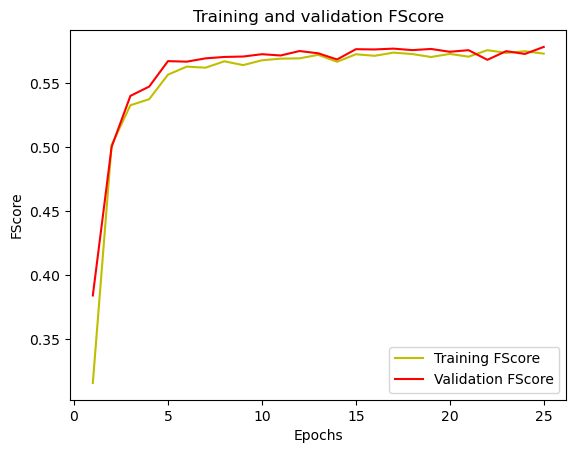

C:\Users\786ah\anaconda3\envs\tf\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/25
162/162 [==============================] - ETA: 0s - loss: 0.8208 - iou_score: 0.2664 - f1-score: 0.3334
Epoch 1: val_loss improved from inf to 0.95383, saving model to mobilenetv2_best_model.h5
162/162 [==============================] - 26s 119ms/step - loss: 0.8208 - iou_score: 0.2664 - f1-score: 0.3334 - val_loss: 0.9538 - val_iou_score: 0.1145 - val_f1-score: 0.1354
Epoch 2/25
162/162 [==============================] - ETA: 0s - loss: 0.6723 - iou_score: 0.4384 - f1-score: 0.5174
Epoch 2: val_loss did not improve from 0.95383
162/162 [==============================] - 16s 101ms/step - loss: 0.6723 - iou_score: 0.4384 - f1-score: 0.5174 - val_loss: 0.9588 - val_iou_score: 0.1209 - val_f1-score: 0.1482
Epoch 3/25
162/162 [==============================] - ETA: 0s - loss: 0.6266 - iou_score: 0.4593 - f1-score: 0.5330
Epoch 3: val_loss did not improve from 0.95383
162/162 [==============================] - 17s 102ms/step - loss: 0.6266 - iou_score: 0.4593 - f1-score: 0.5330 

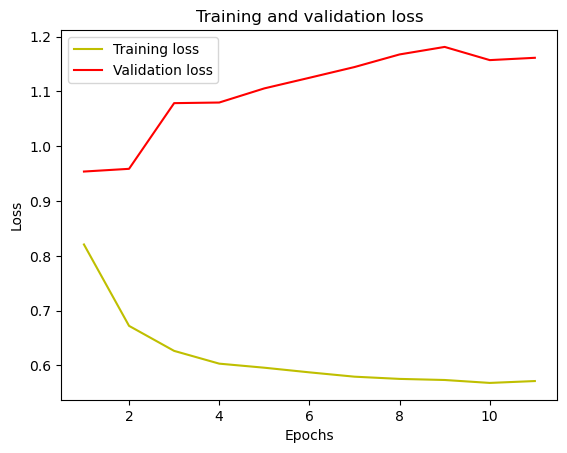

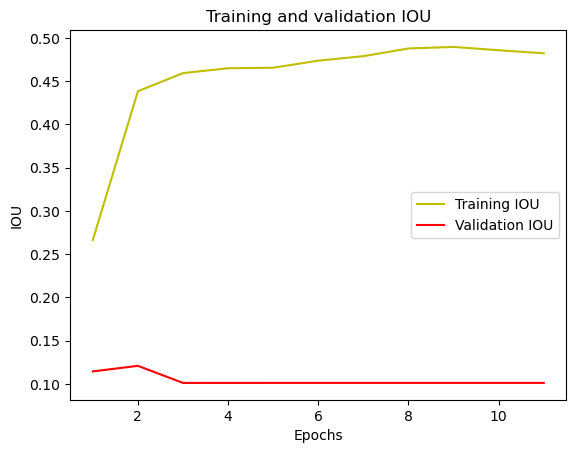

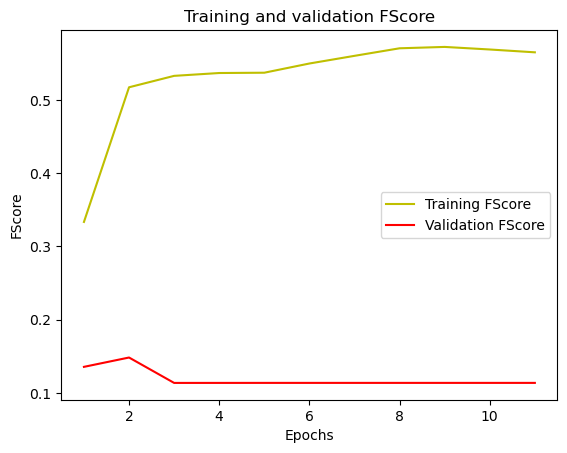

Epoch 1/25
162/162 [==============================] - ETA: 0s - loss: 0.8468 - iou_score: 0.1270 - f1-score: 0.1771
Epoch 1: val_loss improved from inf to 0.97929, saving model to vgg16_best_model.h5
162/162 [==============================] - 24s 121ms/step - loss: 0.8468 - iou_score: 0.1270 - f1-score: 0.1771 - val_loss: 0.9793 - val_iou_score: 0.0899 - val_f1-score: 0.1237
Epoch 2/25
162/162 [==============================] - ETA: 0s - loss: 0.6855 - iou_score: 0.3475 - f1-score: 0.4278
Epoch 2: val_loss did not improve from 0.97929
162/162 [==============================] - 16s 102ms/step - loss: 0.6855 - iou_score: 0.3475 - f1-score: 0.4278 - val_loss: 1.1390 - val_iou_score: 0.0173 - val_f1-score: 0.0313
Epoch 3/25
162/162 [==============================] - ETA: 0s - loss: 0.6308 - iou_score: 0.4411 - f1-score: 0.5146
Epoch 3: val_loss did not improve from 0.97929
162/162 [==============================] - 18s 109ms/step - loss: 0.6308 - iou_score: 0.4411 - f1-score: 0.5146 - val_

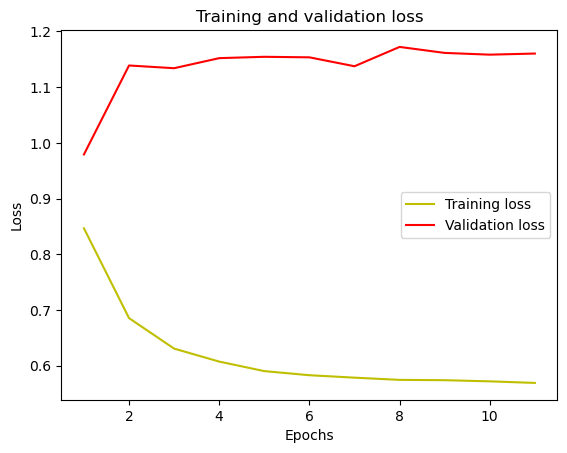

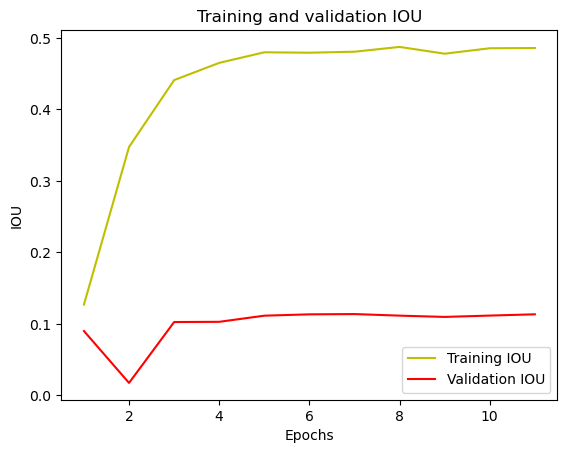

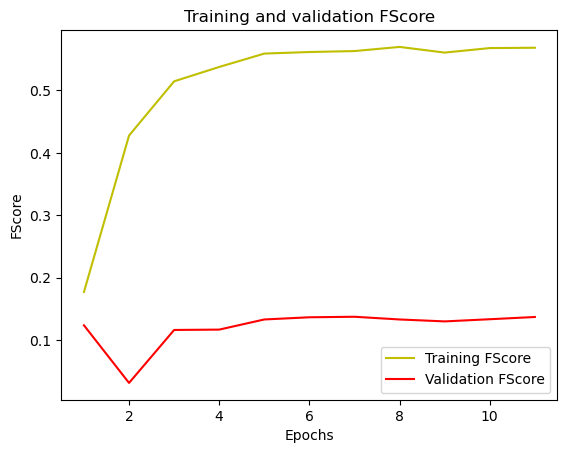

In [14]:
# Main script
if __name__ == "__main__":
    # Load and preprocess data
    train_images, train_masks = load_images(DATA_PATH, MASK_PATH)

    train_masks_encoded = preprocess_masks(train_masks)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(train_images, train_masks_encoded)

    y_train_cat = to_categorical(y_train, num_classes=N_CLASSES)
    y_val_cat = to_categorical(y_val, num_classes=N_CLASSES)
    y_test_cat = to_categorical(y_test, num_classes=N_CLASSES)

    # Augment data
    train_generator = augment_data(X_train, y_train_cat, BATCH_SIZE)

    # Train and evaluate models
    for backbone in BACKBONES:
        model, preprocess_input = build_model(backbone, N_CLASSES)
        X_train_preprocessed = preprocess_input(X_train)
        X_val_preprocessed = preprocess_input(X_val)

        # Model checkpoints
        checkpoint = ModelCheckpoint(f'{backbone}_best_model.h5', monitor='val_loss', verbose=1, save_best_only=True,
                                     mode='min')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

        history = model.fit(train_generator,
                            validation_data=(X_val_preprocessed, y_val_cat),
                            steps_per_epoch=len(X_train) // BATCH_SIZE,
                            epochs=EPOCHS,
                            callbacks=[checkpoint, early_stopping])

        plot_history(history)

In [15]:
    # Load best models and perform ensemble prediction
    models = [load_model(f'{backbone}_best_model.h5', compile=False) for backbone in BACKBONES]
    preds = [model.predict(preprocess_input(X_test)) for model, preprocess_input in
             [(model, sm.get_preprocessing(backbone)) for model, backbone in zip(models, BACKBONES)]]
    weights = [0.3, 0.5, 0.2]
    weighted_preds = np.tensordot(preds, weights, axes=((0), (0)))
    weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)


5/5 [==============================] - 1s 57ms/step


In [30]:
    # Evaluate ensemble prediction
    IOU_weighted = MeanIoU(num_classes=N_CLASSES)
    IOU_weighted.update_state(y_test[:, :, :, 0], weighted_ensemble_prediction)
    print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())


    # Function to calculate Dice coefficient manually
    def dice_coefficient_manual(y_true, y_pred, smooth=1):
        y_true_f = np.ravel(y_true)
        y_pred_f = np.ravel(y_pred)
        intersection = np.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)
    
    df_list = []
    
    for w1 in range(0, 4):
        for w2 in range(0, 4):
            for w3 in range(0, 4):
                wts = [w1 / 10., w2 / 10., w3 / 10.]
                IOU_wted = MeanIoU(num_classes=N_CLASSES)
                
                # Compute weighted predictions
                wted_preds = np.tensordot(preds, wts, axes=((0), (0)))
                wted_ensemble_pred = np.argmax(wted_preds, axis=3)
                
                # Update MeanIoU
                IOU_wted.update_state(y_test[:, :, :, 0], wted_ensemble_pred)
                iou_score = IOU_wted.result().numpy()
                
                # Convert predictions to categorical
                wted_ensemble_pred_cat = to_categorical(wted_ensemble_pred, num_classes=N_CLASSES)
                
                # Calculate Dice score manually
                dice_scores = []
                for i in range(N_CLASSES):
                    dice_score = dice_coefficient_manual(y_test_cat[..., i], wted_ensemble_pred_cat[..., i])
                    dice_scores.append(dice_score)
                mean_dice_score = np.mean(dice_scores)
                
                # Store results in a list
                df_list.append(pd.DataFrame(
                    {'wt1': [wts[0]], 'wt2': [wts[1]], 'wt3': [wts[2]], 'IOU': [iou_score], 'Dice': [mean_dice_score]}))
    
    # Concatenate all DataFrames
    df = pd.concat(df_list, ignore_index=True)
    
    df = df.sort_values('Dice', ascending=False)
    print(df.head())
    
    opt_weights = df.iloc[0, :3].values
    print('Optimized Weights: ', opt_weights)

IOU Score for weighted average ensemble =  0.25331852
    wt1  wt2  wt3       IOU      Dice
32  0.2  0.0  0.0  0.416306  0.519020
48  0.3  0.0  0.0  0.416306  0.519020
16  0.1  0.0  0.0  0.416306  0.519020
52  0.3  0.1  0.0  0.416564  0.518808
49  0.3  0.0  0.1  0.416584  0.518739
Optimized Weights:  [0.2 0.  0. ]


1/1 [==============================] - 1s 860ms/step


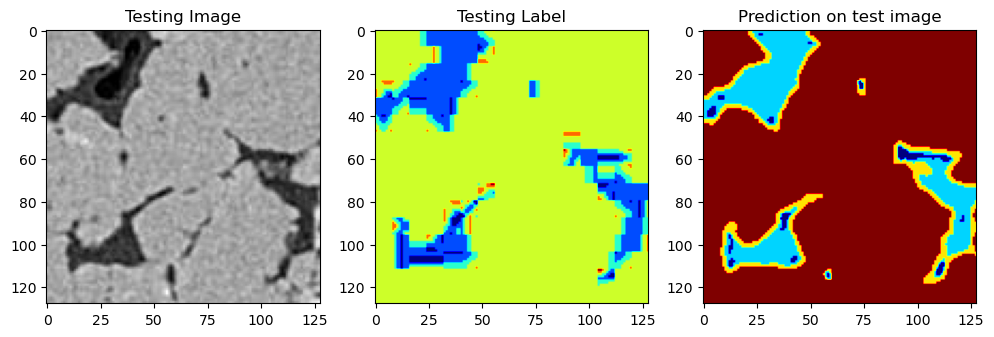

In [31]:
    # Visualize prediction on a test image
    test_img_number = random.randint(0, len(X_test) - 1)
    test_img = X_test[test_img_number]
    ground_truth = y_test[test_img_number]
    test_img_input = np.expand_dims(test_img, 0)

    test_img_input1 = sm.get_preprocessing(BACKBONES[0])(test_img_input)
    test_img_input2 = sm.get_preprocessing(BACKBONES[1])(test_img_input)
    test_img_input3 = sm.get_preprocessing(BACKBONES[2])(test_img_input)

    test_pred1 = models[0].predict(test_img_input1)
    test_pred2 = models[1].predict(test_img_input2)
    test_pred3 = models[2].predict(test_img_input3)

    test_preds = np.array([test_pred1, test_pred2, test_pred3])
    weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0), (0)))
    weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0, :, :]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:, :, 0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:, :, 0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(weighted_ensemble_test_prediction, cmap='jet')
    plt.show()